## Задачи
<ol>
<li>Реализовать функции заполнения изображения импульсным шумом и шумом типа соль-перец.</li>
<li>Реализовать три типа фильтров изображения:</li>
<ul>
<li>Фильтр размытия</li>
<li>Фильтр увеличения резкости</li>
<li>Медианный фильтр избавления от шума</li>
</ul>
</ol>
<br>
Группа: КВБО-07-21<br>
Выполняли: Быковский В.А., Ванюшин С.Р., Данилова Д.П.

## Импорт необходимых библиотек

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

## Загрузка изображения

Image size is: (720, 1080)


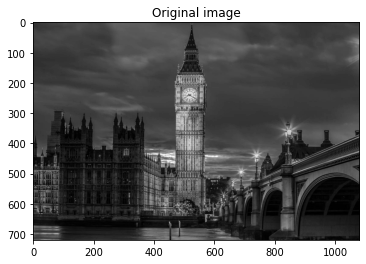

[[ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  61  62  62]
 ...
 [ 87  83  78 ...  15  16  16]
 [134 125 112 ...  13  14  15]
 [150 138 120 ...  11  12  14]]


In [2]:
img = cv2.imread('big-ben.jpg', cv2.IMREAD_GRAYSCALE)

print("Image size is:", img.shape)

plt.figure
plt.imshow(img, cmap='gray')
plt.title("Original image")
plt.show()

print(img)

## Реализация функций заполнения изображения шумом

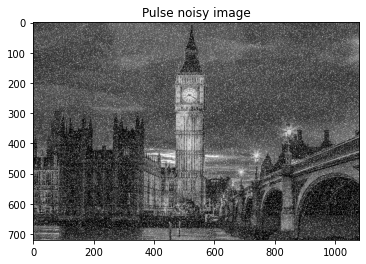

[[ 52  52 255 ...  60 255 255]
 [ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  61  62  62]
 ...
 [ 87  83  78 ...  15  16  16]
 [134 125 112 ...  13  14  15]
 [150 138 120 ...  11  12  14]]


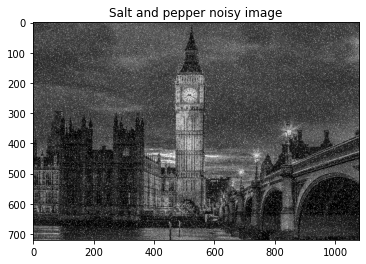

[[ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  60  61  61]
 [ 52  52  52 ... 255  62 255]
 ...
 [ 87  83  78 ...  15 255  16]
 [134 125 112 ...  13  14  15]
 [150 138 120 ...  11  12  14]]


In [3]:
def impulse_noise_generator(img):
    """
    Осуществляет заполнение изображения импульсным шумом
    
    :param img: матрица исходного изображения
    
    :return noisy_img: матрица зашумленного изображения
    """
    noise_share = 0.1
    noisy_img = np.copy(img)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if noise_share >= random.random():
                noisy_img[i, j] = 255
                
    return noisy_img


def salt_and_pepper_noise_generator(img):
    """
    Осуществляет заполнение изображения шумом типа соль-перец
    
    :param img: матрица исходного изображения
    
    :return noisy_img: матрица зашумленного изображения
    """
    noise_share = 0.1
    noisy_img = np.copy(img)
    
    for i in range(noisy_img.shape[0]):
        for j in range(noisy_img.shape[1]):
            if noise_share >= random.random():
                noisy_img[i, j] = 0 if bool(random.getrandbits(1)) else 255
                
    return noisy_img
    
impulse_noisy_img = impulse_noise_generator(img)
salt_and_pepper_noisy_img = salt_and_pepper_noise_generator(img)

plt.imshow(impulse_noisy_img, cmap='gray')
plt.title("Pulse noisy image")
plt.show()

print(impulse_noisy_img)

plt.imshow(salt_and_pepper_noisy_img, cmap='gray')
plt.title("Salt and pepper noisy image")
plt.show()

print(salt_and_pepper_noisy_img)

## Реализация функции расширения изображения и функции операции свёртки

In [4]:
def image_expansion(img, kernel_dimension=3):
    """
    Осуществляет расширение матрицы исходного изображения нулями со всех сторон
    
    :param img: матрица исходного изображения
    :param kernel_dimension: размерность матрицы фильтра для каждой из осей. Принимаются только нечётные значения, начиная c 0.
    
    :return extended_img: расширенная матрица
    """
    diff = kernel_dimension // 2 # величина расширения
    
    extended_img = np.concatenate(
        (np.zeros((img.shape[0], diff), dtype='uint8'),
         img,
         np.zeros((img.shape[0], diff), dtype='uint8'),
         ),
        dtype='uint8',
        axis=1
    )

    extended_img = np.concatenate(
        (np.zeros((diff, img.shape[1] + diff * 2), dtype='uint8'),
         extended_img,
         np.zeros((diff, img.shape[1] + diff * 2), dtype='uint8'),
         ),
        dtype='uint8'
    )

    return extended_img


def convolution(submatrix, kernel):
    """
    Осуществляет итерацию операции свёртки
    
    :param submatrix: подматрица исходной матрицы, размерность которой соответствует размерности ядра свёртки
    :param kernel: ядро свёртки
    
    :return new_value: результат операции свертки
    
    """
    new_value = np.sum(np.multiply(submatrix, kernel))
    
    if new_value > 255:
        new_value = 255
    elif new_value < 0:
        new_value = 0
    
    return new_value

## Реализация функций фильтрации изображения

In [5]:
def blur_filter(img, kernel_dimension=3):
    """
    Осуществляет размытие изображения
    
    :param img: матрица исходного изображения
    :param kernel_dimension: размерность матрицы фильтра для каждой из осей. Принимаются только нечётные значения, начиная c 0.
    
    :return blur_img: матрица размытого изображения
    """
    diff = kernel_dimension // 2 # величина расширения
    
    blur_img = np.zeros(img.shape, dtype='uint8')
    img = image_expansion(img, kernel_dimension)
    blur_kernel = 1/np.power(kernel_dimension, 2) * np.array([[1] * kernel_dimension] * kernel_dimension)
    
    for i in range(diff, img.shape[0] - diff):
        for j in range(diff, img.shape[1] - diff):
            submatrix = img[i - diff : i + diff + 1, j - diff : j + diff + 1]
            blur_img[i - diff, j - diff] = convolution(submatrix, blur_kernel)
    
    return blur_img


def sharp_filter(img, kernel_dimension=3):
    """
    Осуществляет увеличение резкости изображения
    
    :param img: матрица исходного изображения
    
    :return sharp_img: матрица изображения с увеличенной резкостью
    """
    diff = kernel_dimension // 2 # величина расширения
    
    sharp_img = np.zeros(img.shape, dtype='uint8')
    img = image_expansion(img, kernel_dimension)
    sharp_kernel = -np.ones((kernel_dimension, kernel_dimension))
    sharp_kernel[diff, diff] = kernel_dimension ** 2
    
    for i in range(diff, img.shape[0] - diff):
        for j in range(diff, img.shape[1] - diff):
            submatrix = img[i - diff : i + diff + 1, j - diff : j + diff + 1]
            sharp_img[i - diff, j - diff] = convolution(submatrix, sharp_kernel)
    
    return sharp_img


def median_filter(img, kernel_dimension=3):
    """
    Осуществляет фильтрацию изображения от шумов
    
    :param img: матрица исходного изображения
    :param kernel_dimension: размерность матрицы фильтра для каждой из осей. Принимаются только нечётные значения, начиная c 0.
    
    :return median_img: отфильтрованное изображение
    """
    diff = kernel_dimension // 2 # величина расширения
    
    median_img = np.zeros(img.shape, dtype='uint8')
    img = image_expansion(img, kernel_dimension)
    
    for i in range(diff, img.shape[0] - diff):
        for j in range(diff, img.shape[1] - diff):
            submatrix = img[i - diff : i + diff + 1, j - diff : j + diff + 1]
            
            sorted_env = np.sort(submatrix.flatten())
            median_img[i - diff, j - diff] = sorted_env[len(sorted_env) // 2]

    return median_img

## Окончательный результат

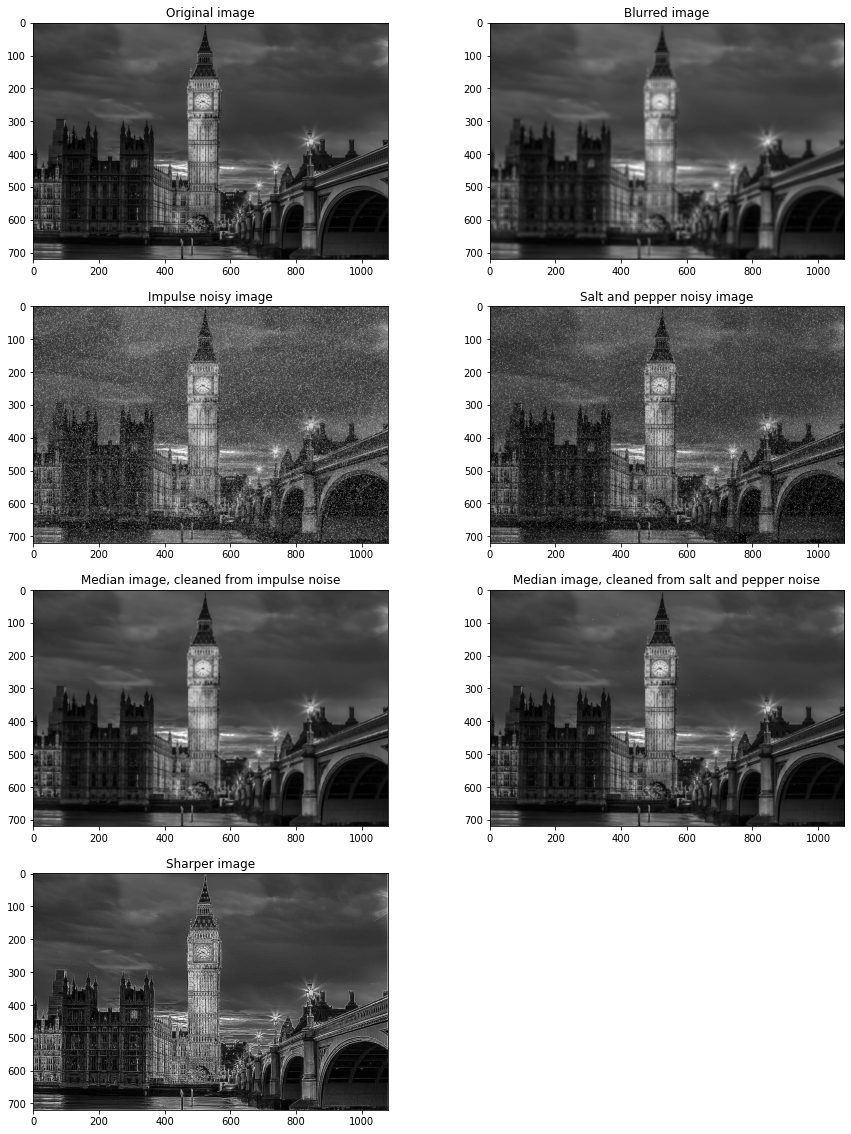

In [6]:
plt.figure(figsize=[15, 20])

plt.subplot(421)
plt.imshow(img, cmap='gray')
plt.title("Original image")

plt.subplot(422)
plt.imshow(blur_filter(img, 9), cmap='gray')
plt.title("Blurred image")

plt.subplot(423)
plt.imshow(impulse_noisy_img, cmap='gray')
plt.title("Impulse noisy image")

plt.subplot(424)
plt.imshow(salt_and_pepper_noisy_img, cmap='gray')
plt.title("Salt and pepper noisy image")

plt.subplot(425)
plt.imshow(median_filter(impulse_noisy_img, 5), cmap='gray')
plt.title("Median image, cleaned from impulse noise")

plt.subplot(426)
plt.imshow(median_filter(salt_and_pepper_noisy_img), cmap='gray')
plt.title("Median image, cleaned from salt and pepper noise")

plt.subplot(427)
plt.imshow(sharp_filter(img), cmap='gray')
plt.title("Sharper image")

plt.show()